In [1]:
import numpy as np
import skimage
from skimage import io, transform
import matplotlib.pyplot as plt
import torch
from torch.utils import data
from dataset import PlacesDataset
from data_dicts import Dicts
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam,SGD
from sklearn.metrics import jaccard_similarity_score as jss
from skimage.segmentation import find_boundaries as fb
from unet_model import Unet

In [2]:
dic=Dicts()
train_files,val_files=dic.get_dicts()

In [3]:
train_dataset=PlacesDataset(train_files,augment=10, transforms=True)
test_dataset=PlacesDataset(val_files,augment=10,transforms=True)

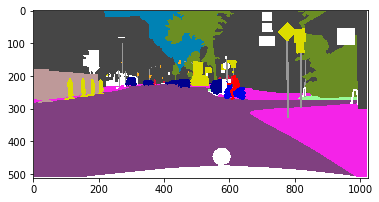

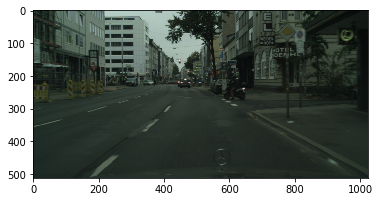

In [5]:
img,label,mask=train_dataset[140]
plt.imshow(train_dataset.decode_segmap(label.numpy()))
plt.show()
plt.imshow(img.numpy().transpose(1,2,0)[:,:,::-1])

In [6]:
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1)

In [7]:
unet=Unet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)
unet=unet.to(device)

cuda


In [12]:
def test_loss_function(output_model,target):
    n,c,h,w=output_model.size()
    nt,ht,wt=target.size()
    
    if (h!=ht and w!=wt):
        output_model=F.interpolate(output_model, size=(ht, wt), mode="bilinear", align_corners=True)
        
    output_model=F.softmax(output_model.squeeze(0),dim=0).transpose(0,1).transpose(1,2)
    predicted=np.zeros((ht,wt))
    target=target.squeeze(0).cpu().numpy().reshape(-1)
    output_model=output_model.cpu().numpy()
    predicted=np.argmax(output_model,axis=2)
    predicted=predicted.reshape(-1)
    target[target==255]=19
    score=jss(target,predicted)
    return score

In [13]:
def test_IoU(input_image,target_image):
    with torch.no_grad():
        output_image=unet(input_image)
        loss=test_loss_function(output_image,target_image)
        return loss

In [15]:
checkpoint = torch.load('saved/model_fl.pth')
unet.load_state_dict(checkpoint['model_state_dict'])
batch = checkpoint['epoch']
tl = checkpoint['tl']
vl = checkpoint['vl']
unet.train()

Unet(
  (conv1a): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv1b): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2a): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2b): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Sequential(
    (0): Conv2d(128,

In [16]:
loss_test=0
for j,inputs in enumerate(test_loader):
    input_image=(inputs[0]).to(device)
    target_image=(inputs[1]).to(device)
    loss_test+=test_IoU(input_image,target_image)
loss_test=loss_test/(j+1)
print (loss_test)

0.7937756080627442


In [ ]:
for j,inputs in enumerate(test_loader):
    input_image=(inputs[0]).to(device)
    target=(inputs[1]).to(device)
    with torch.no_grad():
        output_model=unet(input_image)
        n,c,h,w=output_model.size()
        n,ht,wt=target.size()

        if (h!=ht and w!=wt):
            output_model=F.interpolate(output_model, size=(ht, wt), mode="bilinear", align_corners=True)

        output_model=F.softmax(output_model.squeeze(0),dim=0).transpose(0,1).transpose(1,2)
        #print(output_model.size())
        output_model=output_model.cpu().numpy()
        #print(output_model.shape)
        predicted=np.argmax(output_model,axis=2)
    plt.imshow(train_dataset.decode_segmap(predicted), cmap='gray')
    plt.imshow(input_image.squeeze(0).cpu().numpy().transpose(1,2,0)[:,:,::-1], cmap='jet', alpha=0.5)
    plt.savefig('test_images/predicted/{}.png'.format(j+1))
    plt.imshow(input_image.squeeze(0).cpu().numpy().transpose(1,2,0)[:,:,::-1])
    plt.savefig('test_images/actual/{}.png'.format(j+1))
    plt.imshow(train_dataset.decode_segmap(target.squeeze(0).cpu().numpy()), cmap='gray')
    plt.imshow(input_image.squeeze(0).cpu().numpy().transpose(1,2,0)[:,:,::-1], cmap='jet', alpha=0.5)
    plt.savefig('test_images/target/{}.png'.format(j+1))

In [ ]:
input_image,target,mask=test_dataset[140]
input_image=(input_image.unsqueeze(0)).to(device)
target=target.unsqueeze(0).to(device)
with torch.no_grad():
    output_model=unet(input_image)
    n,c,h,w=output_model.size()
    n,ht,wt=target.size()

    if (h!=ht and w!=wt):
        output_model=F.interpolate(output_model, size=(ht, wt), mode="bilinear", align_corners=True)

    output_model=F.softmax(output_model.squeeze(0),dim=0).transpose(0,1).transpose(1,2)
#print(output_model.size())
    output_model=output_model.cpu().numpy()
#print(output_model.shape)
    predicted=np.argmax(output_model,axis=2)
    predicted[predicted==19]=255
plt.imshow(train_dataset.decode_segmap(predicted), cmap='gray')
plt.imshow(input_image.squeeze(0).cpu().numpy().transpose(1,2,0)[:,:,::-1], cmap='jet', alpha=0.5)
plt.show()
plt.imshow(input_image.squeeze(0).cpu().numpy().transpose(1,2,0)[:,:,::-1])
plt.show()
plt.imshow(train_dataset.decode_segmap(target.squeeze(0).cpu().numpy()), cmap='gray')
plt.imshow(input_image.squeeze(0).cpu().numpy().transpose(1,2,0)[:,:,::-1], cmap='jet', alpha=0.5)
plt.show()